In [12]:
import pickle
import yaml
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def saveFig(name, fig):
    fig.savefig(
        name,
        dpi=None,
        facecolor=fig.get_facecolor(),
        edgecolor="none",
        orientation="portrait",
        format="png",
        transparent=False,
        bbox_inches="tight",
        pad_inches=0.2,
        metadata=None,
    )

In [14]:
# Update the path belows to the multirun directories containing the results for FedProx and FedAvg
path_fedprox_resutls = "../multirun/2023-09-13/19-13-06"
path_fedavg_results = "../multirun/2023-09-13/19-13-30"

In [15]:
# load all results
def read_pickle_and_config(path_to_pickle):
    with open(path_to_pickle, "rb") as handle:
        data = pickle.load(handle)

    config_path = Path(path_to_pickle).parent / ".hydra" / "config.yaml"
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    return data, config


# loads results.pkl and config of each run
def process_data(path_fedprox_results):
    res_list = []
    for results in list(Path(path_fedprox_results).glob("**/results.pkl")):
        data, config = read_pickle_and_config(results)
        data_cen = data["history"].metrics_centralized
        loss_cen = data["history"].losses_centralized
        stragglers = config["stragglers_fraction"]
        res_list.append(
            {
                "stragglers": stragglers,
                "mu": config["mu"],
                "accuracy": np.array([d[1] for d in data_cen["accuracy"]]),
                "loss": np.array([d[1] for d in loss_cen]),
            }
        )

    # to DataFrame
    df = pd.DataFrame.from_dict(res_list)
    # Grouping the DataFrame by 'mu' and 'stragglers' columns
    grouped_df = df.groupby(["mu", "stragglers"])

    # Calculating the mean and standard deviation of 'accuracy' and 'loss' columns
    mean_df = grouped_df[["accuracy", "loss"]].mean()
    return mean_df.reset_index()

In [16]:
fedprox_df = process_data(path_fedprox_resutls)
fedavg_df = process_data(path_fedavg_results)

In [17]:
# let's add a new column to each dataframe that we'll use as label
fedprox_df["strategy"] = "FedProx"
fedavg_df["strategy"] = "FedAvg"

# Now let's fuse both datframes
df = pd.concat([fedprox_df, fedavg_df])
df = df.reset_index()
df

,index,mu,stragglers,accuracy,loss,strategy
0,0,0.0,0.0,"[0.11398, 0.20268000000000003, 0.2750200000000...","[0.24347737233877184, 0.3574004814302921, 0.26...",FedProx
1,1,0.0,0.5,"[0.12345999999999999, 0.24006, 0.3294399999999...","[0.24140010815143587, 0.2585200372099877, 0.22...",FedProx
2,2,0.0,0.9,"[0.09314000000000001, 0.26774, 0.2599399999999...","[0.24544234560012815, 0.2665142494344711, 0.30...",FedProx
3,3,2.0,0.0,"[0.08660000000000001, 0.25604, 0.2977800000000...","[0.24687931244373318, 0.2223488856935501, 0.21...",FedProx
4,4,2.0,0.5,"[0.07633999999999999, 0.21364, 0.2147800000000...","[0.24682008695602414, 0.2371165024828911, 0.22...",FedProx
5,5,2.0,0.9,"[0.09004, 0.20128, 0.34344, 0.3649399999999999...","[0.2467724170899391, 0.25821806485176085, 0.19...",FedProx
6,0,0.0,0.0,"[0.09038, 0.21739999999999998, 0.24558, 0.3283...","[0.25056266946554184, 0.30652024932622907, 0.3...",FedAvg
7,1,0.0,0.5,"[0.09072, 0.19036, 0.21808, 0.30552, 0.36902, ...","[0.24473455918073653, 0.44304580656528475, 0.4...",FedAvg
8,2,0.0,0.9,"[0.07846, 0.19234, 0.20246, 0.20526, 0.2831400...","[0.24681811848163604, 0.3380656589162349, 0.36...",FedAvg


In [18]:
def viz(dataframe):
    fig, axs = plt.subplots(figsize=(18, 12), nrows=3, ncols=2)
    for col_idx, col_label in enumerate(["loss", "accuracy"]):
        for row_idx, strag_ratio in enumerate([0.0, 0.5, 0.9]):
            ax = axs[row_idx, col_idx]
            exp_data = dataframe.loc[(dataframe["stragglers"] == strag_ratio)]
            for _, exp in exp_data.iterrows():
                y = exp[col_label]
                rounds_array = np.array(range(len(y)))
                label = exp["strategy"]
                label = f"{label}($\mu$={exp['mu']})" if label == "FedProx" else label
                ax.plot(rounds_array, y, label=label, linewidth=2.0)

            ax.grid()
            ax.legend(fontsize=14)
            ax.set_xlabel("Round", fontsize=14)
            ax.set_ylabel("Loss" if col_idx == 0 else "Accuracy", fontsize=14)

            ax.tick_params(axis="both", which="major", labelsize=14)
            ax.tick_params(axis="both", which="minor", labelsize=14)

            if col_idx == 0:
                ax.text(-50, 0.2, f"{int(strag_ratio*100)}% Stragglers", fontsize=14)
    return fig

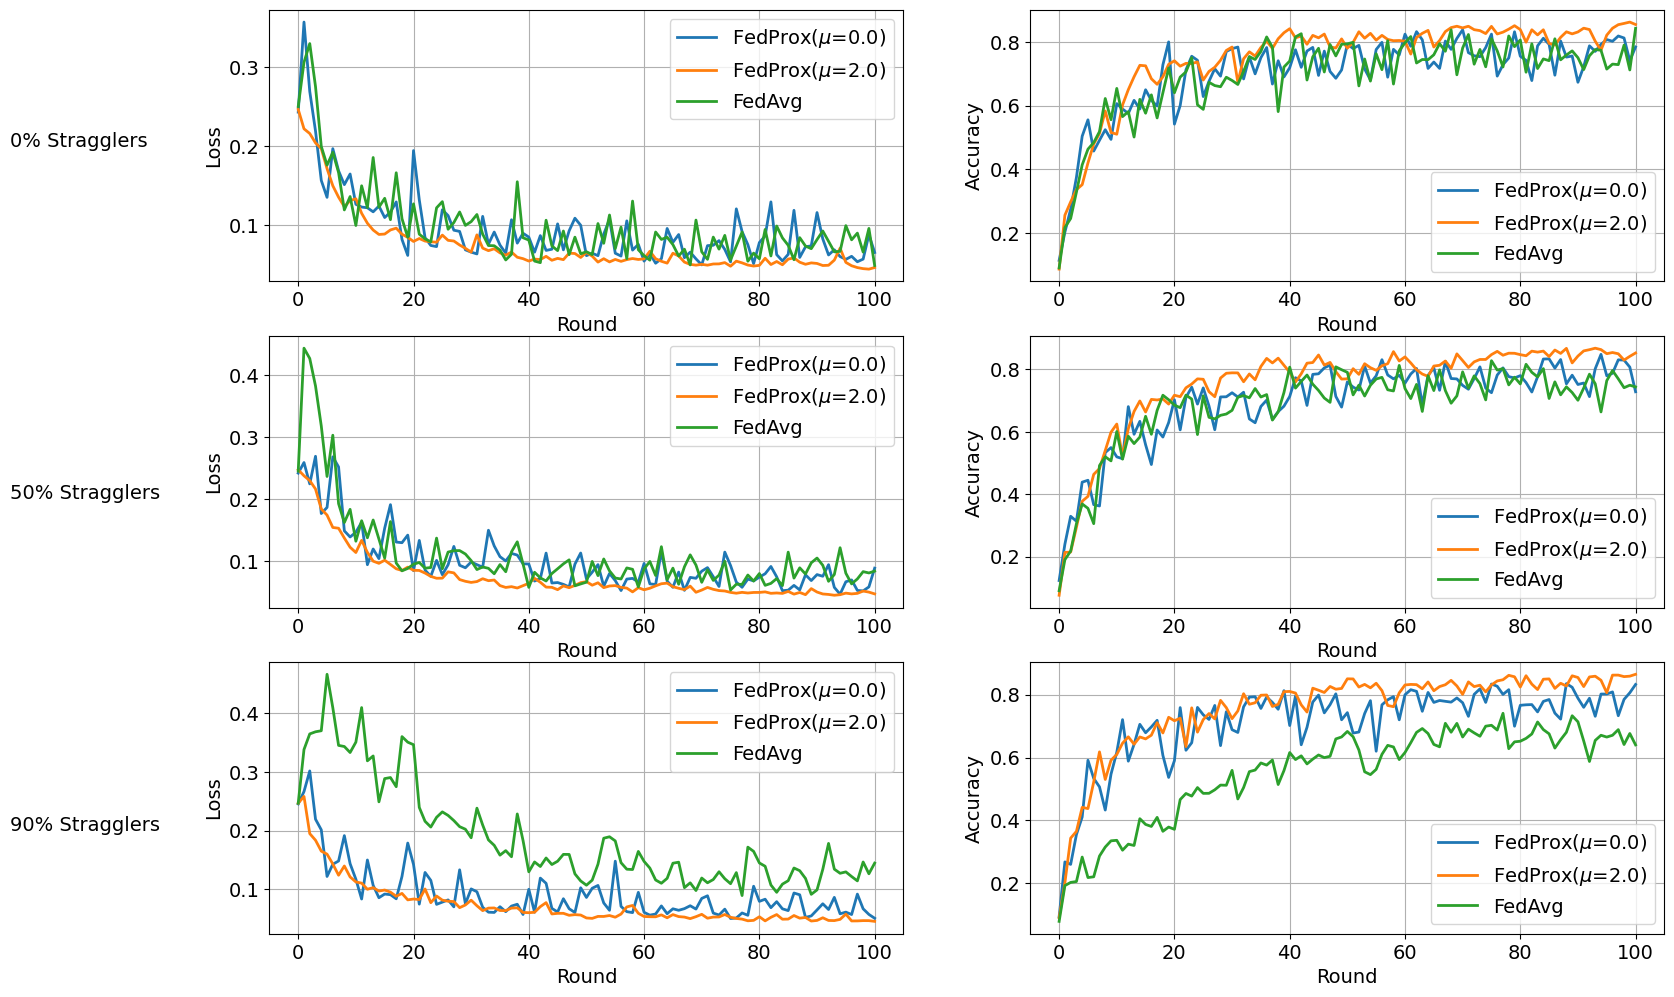

In [19]:
f = viz(df)

In [20]:
saveFig("FedProx_mnist.png", f)